In [1]:
from google.colab import drive

In [2]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## <u>PROBLEM STATEMENT </u>

• <b>DOMAIN:</b> Botanical research

• <b>CONTEXT:</b> University X is currently undergoing some research involving understanding the characteristics of
plant and plant seedlings at various stages of growth. They already have have invested on curating sample
images. They require an automation which can create a classifier capable of determining a plant's species from a
photo<br>
• <b>DATA DESCRIPTION:</b>The dataset comprises of images from 12 plant species. Source: https://www.kaggle.com/c/plant-seedlings-classification/data

• <b>PROJECT OBJECTIVE:</b> University’s management require an automation which can create a classifier capable of
determining a plant's species from a photo<br>
<b>Steps and tasks: </b>

1. Import data. Analyse the dimensions of the data. Visualise the data.
2. Design, train tune and test the best AIML image classifier model using:<br>
    • Supervised learning algorithms <br>
    • Neural networks <br>
    • CNN 

3. Compare the results from the above step along with your detailed observations on the best performing algorithm and
why/how it outperforms other algorithms in this case.
4. Pickle the best performing model.
5. Import the the test image [ from the “ Prediction” folder ] to predict the class. Display the image. Use the best trained
image classifier model to predict the class.

### <u>Solution</u>

### Import data

In [3]:
#import libraries
#%tensorflow_version 2.x
import tensorflow 
tensorflow.__version__

'2.7.0'

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os

import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2

from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA #as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn import svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout,BatchNormalization,InputLayer,Conv2D, MaxPool2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop


From our data description we know that our dataset contain images 12 different plant species. These are stored in 12 different folders, name of these folders are the labels of the species. We have to look into each folder and import all the images.

In [5]:
data_path = glob.glob("/content/gdrive/MyDrive/AIML/Labs/Part-1 - Plant Seedling Classification Data/train/*") #To read subdirectories


In [6]:
folder_label = [os.path.split(i)[-1] for i in data_path] #Extracting folder names in the specified directory
print("Total labels: ",len(folder_label)) #printing number of labels
print("Labels: ",folder_label)

Total labels:  12
Labels:  ['Fat Hen', 'Maize', 'Scentless Mayweed', 'Common Chickweed', 'Small-flowered Cranesbill', 'Common wheat', 'Sugar beet', 'Loose Silky-bent', 'Shepherds Purse', 'Cleavers', 'Black-grass', 'Charlock']


Since we have label names we can visualize each image.

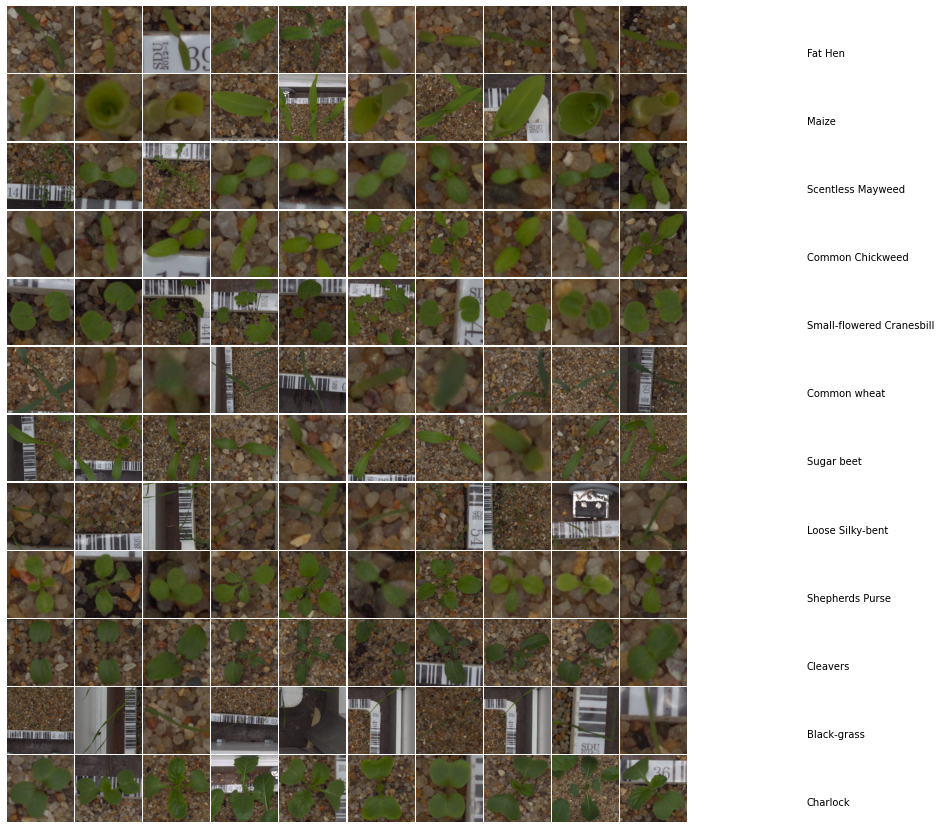

In [7]:
fig = plt.figure(1,(20,15))
img_grid = ImageGrid(fig, 111, nrows_ncols=(12, 10))
no_class = []
c =0
for i, label in enumerate(folder_label):
    paths = glob.glob(os.path.join("/content/gdrive/MyDrive/AIML/Labs/Part-1 - Plant Seedling Classification Data/train/", label, "*.png"))
    no_class.append([label, len(paths)])
    val = np.random.choice(len(paths), size=10)
    name = True
    for j in val:
        ax = img_grid[c]
        if name:
            ax.text(1800, 105, label, verticalalignment="center")
            name = False
        img = cv2.imread(paths[j])
        img = cv2.resize(img, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        c =c+ 1
        
plt.show()

Using ImageGrid we have displayed our dataset corresponding to their labels. Lets check more details like dimension of image

In [8]:
img.shape


(150, 150, 3)

Each image is of size width 150 and height 150, the 3 reperesents its channel which is RGB.

Now we need to store our images into an  array and store corresponding labels to a varaible, for further process

In [10]:
img_df = []
class_df=[]
missing=0
for folder_name in os.listdir("/content/gdrive/MyDrive/AIML/Labs/Part-1 - Plant Seedling Classification Data/train"):
    folder_path = os.path.join("/content/gdrive/MyDrive/AIML/Labs/Part-1 - Plant Seedling Classification Data/train", folder_name)
    class_label = folder_name  
    for image_path in glob.glob(os.path.join(folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: 
          missing += 1
          continue
        img_df.append(image_bgr)
        class_df.append(class_label)


In [11]:
#Total number of images in our dataset
len(img_df)

4767

In [12]:
#Before model building we need to resize images to a base size inorder for proper working
def resize_images(img):
  img = np.array(img).astype(np.uint8)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res


In [13]:
#Saving resized images
img_df = [resize_images(img) for img in img_df]

Now lets look into shape of resized images 

In [14]:
images = np.array(img_df)
classes = np.array(class_df)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (4767, 256, 256, 3)
classes shape:  (4767,)


It shows that we have total 4767 images each with width and height 256, having RGB color frame. And there is also 4767 dimensions

Lets visualize the distribution of our data in each class

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


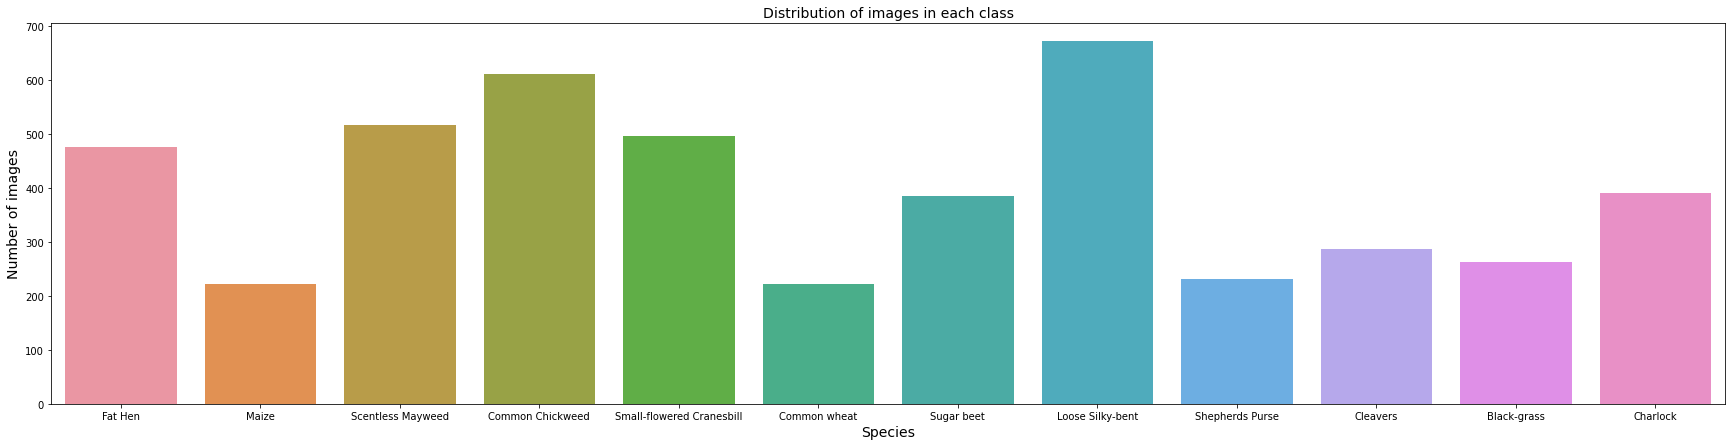

In [15]:
fig1, ax1 = plt.subplots(figsize=(30, 7))
  

plt.xlabel("Species", fontsize = 14)

plt.title("Distribution of images in each class", fontsize=14)
sns.countplot(classes,ax=ax1);
plt.ylabel("Number of images", fontsize = 14)
plt.show()


From above we can see it is not distributed normally. The plant Loose Silky-bent have highest number of images above 600 images. Dataset is imbalanced

###Now we nee to preprocess our images inorder for our machine to understand which is in numbers.Also we have to suppress unwanted noises and disturbance from the images and enhacne their features for our model building.

Creating fucntions for data preprocessing such as converting from rgb to hsv, segmentation,sharpening etc

In [16]:
#Function to convert RGB to HSV and applying morphological transformations

def mask_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

In [17]:
#Function for applying segmentaion
def segment_plant(image):
    mask = mask_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

In [18]:
#Function for applying sharpening
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [19]:
#Now lets comnbine all the three functions as data preprocessing
def preprocess(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen
for indx, image in enumerate(images):
  try:
    images[indx] = preprocess(image)   
  except:
    print(indx)
    continue

Since we have done image preprocessing, before going into model building we need to create a dataframe to record performance of each model.

In [20]:
performance_df =  pd.DataFrame(columns=['Model', 'Accuracy', 'Loss','Predicted Class'])

We need to laod our test image for prediction


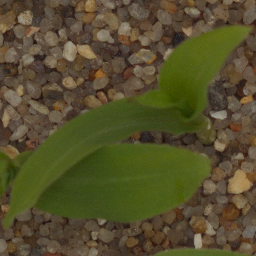

The shape of image to be predicted is:'(578, 578, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 256, 256, 3)'


In [21]:
img_pred = cv2.imread('/content/gdrive/MyDrive/AIML/Labs/Part-1 - Plant Seedling Classification Data/Seedling - Prediction/Predict.png')
img_pred_resize = cv2.resize(img_pred,(256,256), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_pred_resize)
img_predict = np.expand_dims(img_pred_resize, axis=0)
print(f"The shape of image to be predicted is:'{img_pred.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict.shape}'")

We have imported the predict image now we need to encode our label names inorder for machine to understand.

In [22]:
enc = LabelEncoder()
y = enc.fit_transform(classes)
num_classes = len(np.unique(y))
num_classes

12

In [23]:
#Now lets split our train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=60)


In [24]:
#We need validation data, so we split test and validation set
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=2)


#Now we can start data modeling using Supervised learning algorithms, Neural Network, CNN.

##<b><u>Classification using Supervised Learning Techniques</u></b>

### SVM

For support vector machine data having higher number of features make it difficult to build model. Here our data contains almost 256*256 (65536) features for each image. We need to reduce the number of features, we use PCA for this purpose.<br>
<br>But for performing PCA on colored image we need to flatten the image and split it into their red, green blue channels. Then PCA is applied to each channel and at last these channels are combined

In [25]:
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [26]:
#Here we are splitting the data as r,g,b and inputing each into the flatten function
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)
X_val_r, X_val_g, X_val_b = flatten(X_val)

In [27]:
#For PCA we need to specify the number of features we are considering. Here we take it as 500
no_components = 500
X_train_pca_r = PCA(n_components=no_components, whiten=True).fit(X_train_r)
X_train_pca_g = PCA(n_components=no_components, whiten=True).fit(X_train_g)
X_train_pca_b = PCA(n_components=no_components, whiten=True).fit(X_train_b)

X_test_pca_r = PCA(n_components=no_components, whiten=True).fit(X_test_r)
X_test_pca_g = PCA(n_components=no_components, whiten=True).fit(X_test_g)
X_test_pca_b = PCA(n_components=no_components, whiten=True).fit(X_test_b)

X_val_pca_r = PCA(n_components=no_components, whiten=True).fit(X_val_r)
X_val_pca_g = PCA(n_components=no_components, whiten=True).fit(X_val_g)
X_val_pca_b = PCA(n_components=no_components, whiten=True).fit(X_val_b)

In [28]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

In [29]:
#Now we need to check the variance percentage of train,test and validation data using 500 features
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()

(0.9556460006364047, 0.9780914341668283, 0.9705294213098454)

From above we can observe that with 500 components the training data can explain 95% of variance of data, test and validation can explain 97%of variance.

In [30]:
#Lets concatenate r,g,b channels
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

Since we are done with PCA lets train SVM model

In [31]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

Now lets predict using SVM

In [32]:
#We need to perfrom PCA on test image, so similar steps
pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [33]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [34]:
#Predicting using SVM
pred_svm = clf.predict(X_pred_pca)[0]
y_pred = clf.predict(X_test_pca)
print(f"The predicted label is:'{pred_svm}'")
svm_accuracy= metrics.accuracy_score(y_test, y_pred)

The predicted label is:'7'


In [35]:
performance_df = performance_df.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_svm                                      
                                              }, ignore_index=True)

performance_df

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.195804,NA,7


SVM predicted with accuracy of only 19.5% which is not enough

###Random Forest Classifier Model

In [36]:
#Training the model
param_grid=[
            {'n_estimators':[100,200],
             'min_samples_leaf':[2,3]}
           ]
rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': [2, 3],
                          'n_estimators': [100, 200]}],
             verbose=10)

In [37]:
#Predicitng using RF Model
rf_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_rf = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_rf}'")

The predicted label is:'1'


In [38]:
performance_df = performance_df.append({'Model':'RF',
                                              'Accuracy': rf_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_rf                                      
                                              }, ignore_index=True)

performance_df

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.195804,NA,7
1,RF,0.239161,NA,1


The RF classifier has slighlty higher accuracy (23.9%) but it is not enough

##<b><u>Classification using Artificial Neural Network</u></b>

In [39]:
#For ANN we wil enocde the label names with LabelBinarizer function because it encodes the actual class as 1 and rest of the classes as 0.
enc = LabelBinarizer()
y2 = enc.fit_transform(classes)

In [40]:
#Splitting the data into train,test and validation sets with new label encoding
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=60)

In [41]:
#Spliting into test and validation set 
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=2)

Training ANN

In [42]:
#Function to train our model, here we use relu as activation function for input and softmax for output .
def ann_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  

  model = Sequential()

  model.add(InputLayer(input_shape=(height, width, num_channels)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  opt = tensorflow.keras.optimizers.Adam(lr=0.000001)
  model.compile(optimizer = opt, loss = loss, metrics = metrics)

  model.summary()
  return model

In [43]:
#The shape of feature and target is needed as input
X_train.shape,y_train.shape

((3336, 256, 256, 3), (3336, 12))

In [44]:
#Passing arguments
ann = ann_model(256,256,3,12)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 batch_normalization (BatchN  (None, 196608)           786432    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              201327616 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 512)               5

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [45]:
#Validating the model using train and validate data
history = ann.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                 )

Epoch 1/50
105/105 [==============================] - 16s 118ms/step - loss: 2.7238 - accuracy: 0.1841 - val_loss: 2.0403 - val_accuracy: 0.3338
Epoch 2/50
105/105 [==============================] - 12s 115ms/step - loss: 2.1095 - accuracy: 0.3186 - val_loss: 1.6374 - val_accuracy: 0.4413
Epoch 3/50
105/105 [==============================] - 12s 115ms/step - loss: 1.8539 - accuracy: 0.3876 - val_loss: 1.4870 - val_accuracy: 0.4804
Epoch 4/50
105/105 [==============================] - 12s 115ms/step - loss: 1.6531 - accuracy: 0.4499 - val_loss: 1.3978 - val_accuracy: 0.5168
Epoch 5/50
105/105 [==============================] - 12s 114ms/step - loss: 1.4992 - accuracy: 0.4856 - val_loss: 1.3414 - val_accuracy: 0.5433
Epoch 6/50
105/105 [==============================] - 12s 114ms/step - loss: 1.4103 - accuracy: 0.5291 - val_loss: 1.2854 - val_accuracy: 0.5573
Epoch 7/50
105/105 [==============================] - 12s 114ms/step - loss: 1.2882 - accuracy: 0.5632 - val_loss: 1.2553 - val_ac

In [46]:
ann_loss, ann_accuracy = ann.evaluate(X_test, y_test, verbose=1)
print('Test loss:', ann_loss)
print('Test accuracy:', ann_accuracy)

23/23 [==============================] - 1s 28ms/step - loss: 1.0459 - accuracy: 0.6392
Test loss: 1.0459121465682983
Test accuracy: 0.6391608119010925


ANN gives an accuracy of 63%

In [47]:
#Now lets predict using ANN model
ann_predict = np.argmax(ann.predict(img_predict))
print('The predicted  label:', ann_predict)

The predicted  label: 1


In [48]:
performance_df = performance_df.append({'Model':'ANN',
                                              'Accuracy': ann_accuracy,
                                              'Loss': ann_loss,
                                              'Predicted Class': ann_predict                                      
                                              }, ignore_index=True)

performance_df

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.195804,NA,7
1,RF,0.239161,NA,1
2,ANN,0.639161,1.04591,1


The ANN model has higher accuracy than the other two. 

##<b><u>Classification using Convolution Neural Network(CNN)

Training CNN model

In [49]:
#Function to train model
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model


In [50]:
#Same as ANN passing the dimensions as arguments to the function
cnn = cnn_model(256,256,3,12)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [51]:
#Training the moddel with validation data and train data
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val))
                  

Epoch 1/50
105/105 [==============================] - 60s 440ms/step - loss: 2.9624 - accuracy: 0.1235 - val_loss: 2.4391 - val_accuracy: 0.1550
Epoch 2/50
105/105 [==============================] - 42s 397ms/step - loss: 2.3108 - accuracy: 0.2116 - val_loss: 3.4226 - val_accuracy: 0.1550
Epoch 3/50
105/105 [==============================] - 42s 396ms/step - loss: 2.0352 - accuracy: 0.3297 - val_loss: 1.9194 - val_accuracy: 0.3799
Epoch 4/50
105/105 [==============================] - 42s 396ms/step - loss: 1.7276 - accuracy: 0.4122 - val_loss: 1.8090 - val_accuracy: 0.3799
Epoch 5/50
105/105 [==============================] - 42s 396ms/step - loss: 1.5419 - accuracy: 0.4676 - val_loss: 1.4965 - val_accuracy: 0.5321
Epoch 6/50
105/105 [==============================] - 42s 396ms/step - loss: 1.4717 - accuracy: 0.5201 - val_loss: 1.8552 - val_accuracy: 0.3478
Epoch 7/50
105/105 [==============================] - 42s 395ms/step - loss: 1.3023 - accuracy: 0.5522 - val_loss: 1.2837 - val_ac

In [52]:
#Finding the accuracy and loss
cnn_loss, cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss)
print('Test accuracy:', cnn_accuracy)


23/23 [==============================] - 4s 180ms/step - loss: 0.5558 - accuracy: 0.8182
Test loss: 0.5558393597602844
Test accuracy: 0.8181818127632141


We got a test accuracy of 81%

In [53]:
#Predicitng using CNN
cnn_predict = np.argmax(cnn.predict(img_predict))
print('The predicted  label:', cnn_predict)

The predicted  label: 8


In [54]:
performance_df = performance_df.append({'Model':'CNN',
                                              'Accuracy': cnn_accuracy,
                                              'Loss': cnn_loss,
                                              'Predicted Class': cnn_predict                                      
                                              }, ignore_index=True)

performance_df

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.195804,NA,7
1,RF,0.239161,NA,1
2,ANN,0.639161,1.04591,1
3,CNN,0.818182,0.555839,8


The CNN Classifier has better accuracy than the other models
So we should save this model

In [56]:
cnn.save("CNN_PlantSeedling_ImageClassification.h5")

Convolutional Neural Network outperforms Neural Network and which in turn out perform Supervised Learning models. Here we have higher accuracy and less loss. Unlike supervised models there is need to extract features here.